# CM50270 Reinforcement Learning: Coursework 3 (Mountain Car)

Please remember: 
(1) Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.
(2) Save your work regularly. 

###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [ ]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

You can visualize the current position of the car using the `plot()` method.

In [ ]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

In [ ]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

In [ ]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1 (50 marks):

For your reference, the pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

Please plot an average learning curve for your agent. This should be a static figure of _precomputed_ results, clearly showing (1) how efficiently an average agent learns, and (2) how good the eventual policy is. In five sentences or less, describe your choice of parameter settings and your results.

In addition, please write code to produce a learning curve for a _single_ agent. This shoud be a dynamic figure that we can produce from scratch by executing your code. This figure can show less detail than the static plot. 


In [134]:
import mountaincar
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [305]:
def createTiling():    
    num_tiles = 10
    min_x = -1.2
    max_x = 0.5
    x_tile_width = (max_x - min_x) / (num_tiles - 2)
    min_y = -0.07
    max_y = 0.07
    y_tile_width = (max_y - min_y) / (num_tiles - 2)
    
    tilings = np.zeros((10, 2, 10))
    
    for tiling in range(num_tiles):
        x_offset = np.random.uniform(0, x_tile_width)
        y_offset = np.random.uniform(0, y_tile_width)     
        xs = np.linspace(min_x, max_x + x_tile_width, num_tiles) - x_offset
        ys = np.linspace(min_y, max_y + y_tile_width, num_tiles) - y_offset
        tilings[tiling] = np.array([xs, ys])
        
    return tilings

def genIndices(state, action, tilings):
    position = np.array(state[0])
    velocity = np.array(state[1])
    
    action_index = action + 1
    
    num_tilings = len(tilings)
    # 10 tilings has been used instead of 9 so that part of the state space is not lost when overlapping tilings
    # This was discussed with Malte in the RL lab
    tiling_length = 10
    tiling_height = 10
    num_tiles = num_tilings * tiling_length * tiling_height
    
    tiles = np.zeros(10, dtype=np.intp)
    for tiling in range(num_tilings):
        xs = tilings[tiling][0]
        ys = tilings[tiling][1]
        xi = np.digitize(position, xs)
        yi = np.digitize(velocity, ys)
        index = (action_index * num_tiles) + (tiling * tiling_length * tiling_height) + xi + (yi * tiling_height)
        tiles[tiling] = int(index)
    return tiles


In [136]:
def e_greedy_action(theta, s, actions, tilings):
        Q = np.zeros(3)
        for a in actions:
            F = genIndices(s, a, tilings)
            Qa = calcQ(F, theta)
            Q[a + 1] = Qa
        maxQ = max(Q)
        if (Q == maxQ).sum() > 1:
            best = [i for i in range(len(actions)) if Q[i] == maxQ]
            i = random.choice(best)
        else:
            i = np.argmax(Q)
        action = actions[i]
        Qa = Q[i]
        return action, Qa

In [137]:
def calcQ(F, theta):
    Qa = 0
    for i in F:
        Qa = Qa + theta[i]
    return Qa

In [345]:
def play(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000) # 10 x 10 x 10 x 3
    
    reward_per_episode = np.zeros(num_episodes)
    
    # Create tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            F = genIndices(state, action, tilings)
            
            # Eligibility traces
            for i in F:
                #e[i] = 1 # Accumulating traces
                e[i] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQ(F, theta)
            #print(Qa)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action(theta, state_, env.actions, tilings)
            else:
                action_ = random.choice(env.actions)
                F = genIndices(state_, action, tilings)
                Qa_ = calcQ(F, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            #print(max(theta))
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
    
    return reward_per_episode
            

In [269]:
n_agents = 20
num_episodes = 100
all_rewards = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards = play(env, num_episodes, alpha=0.05, gamma=1.0, epsilon=0.05, lambda_=0.90, plot=False)
    all_rewards += rewards
    print("Agent", i+1, "complete")

all_rewards = all_rewards / n_agents

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [ ]:
plt.plot(all_rewards)
plt.title("Sarsa(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward per episode')
#plt.legend()
plt.show()

complete


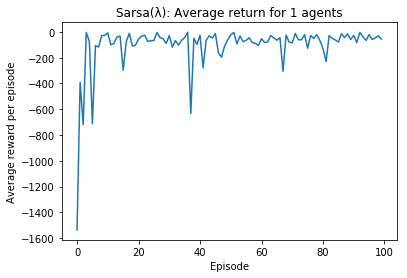

In [311]:
n_agents = 1
num_episodes = 100
all_rewards_one_agent = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards, steps = play(env, num_episodes, alpha=0.05, gamma=1.0, epsilon=0.05, lambda_=0.90, plot=False)
    all_rewards_one_agent += rewards

plt.plot(all_rewards_one_agent)
plt.title("Sarsa(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward per episode')
#plt.legend()
plt.show()

Please make sure that all of your code is above this cell. Here, please insert your static learning curve and answer the verbal questions (describe your choice of parameters and results). 

### Learning curve

<img src="images/sarsa_20_agents.png" style="width: 400px;"/>

### Answer

Using the below image from Sutton & Barto's textbook, it appears the choice of alpha value is more sensitive compared to previous courseworks and, as a result, I found an alpha of 0.05 to be best, as well as a lambda value of 0.92. I have also set epsilon to a low 0.05 because there is sufficient exploration already as a result of initialising the Q values to zero since visited states are valued worse than unexplored states (zero is optimistic as all true values are negative). The below image also shows that replacing traces lead to better performance and my testing confirmed this, meaning I have also decided to use replacing traces in my implementation. My learning curve shows efficient learning of the policy in around 25-30 episodes, with the performance plateauing at under 100 steps per episode after this. The slight variation in performance once the policy has been learned is due to the random starting postion of the car (some positions are worse than others) and the small amount of exploration due to epsilon.

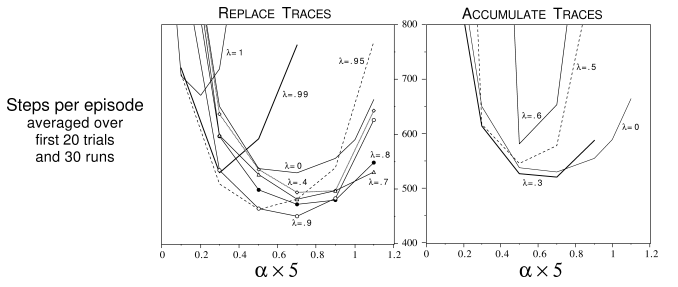



## Part 2 (50 marks)


## (i) Watkin's Q

In [148]:
def play_watkinsQ(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000)
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    # Create tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            F = genIndices(state, action, tilings)
            
            # Eligibility traces
            for i in F:
                #e[i] = 1 # Accumulating traces
                e[i] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQ(F, theta)
            #print(Qa)
            delta = reward - Qa
            
            Q = np.zeros(3)
            for a in env.actions:
                F = genIndices(state_, a, tilings)
                Qa = calcQ(F, theta)
                Q[a + 1] = Qa
            maxQa = max(Q)
            
            delta = delta + gamma * maxQa
            theta = theta + alpha * delta * e
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action(theta, state_, env.actions, tilings)
                e = gamma * lambda_ * e
            else:
                action_ = random.choice(env.actions)
                e = np.zeros(3000)
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step
    
    print("complete")
    return reward_per_episode, steps_per_episode
            

In [158]:
n_agents = 20
num_episodes = 100
all_rewards_WQ = np.zeros(num_episodes)
all_steps_WQ = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards, steps = play_watkinsQ(env, num_episodes, alpha=0.125, gamma=1.0, epsilon=0.01, lambda_=0.92, plot=False)
    all_rewards_WQ += rewards
    all_steps_WQ += steps

all_rewards_WQ = all_rewards_WQ / n_agents
all_steps_WQ = all_steps_WQ / n_agents

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


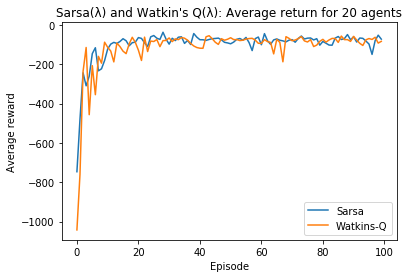

In [159]:
plt.plot(all_rewards, label='Sarsa')
plt.plot(all_rewards_WQ, label='Watkins-Q')
plt.title("Sarsa(λ) and Watkin's Q(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()

## (ii) Non-linear tile spacing

In [320]:
def createSpecialTiling():    
    num_tiles = 10
    min_x = -1.2
    max_x = 0.5
    x_tile_width = (max_x - min_x) / (num_tiles - 2)
    min_y = -0.07
    max_y = 0.07
    y_tile_width = (max_y - min_y) / (num_tiles - 2)
    
    special_tiling = np.array([-1.2, -1.15, -1.05, -0.85, -0.5, 0, 0.35, 0.55, 0.65, 0.7125])
    
    tilings = np.zeros((10, 2, 10))
    
    for tiling in range(num_tiles):
        x_offset = np.random.uniform(0, x_tile_width)
        y_offset = np.random.uniform(0, y_tile_width)     
        xs = special_tiling - x_offset
        ys = np.linspace(min_y, max_y + y_tile_width, num_tiles) - y_offset
        tilings[tiling] = np.array([xs, ys])
        
    return tilings

In [327]:
def play_special_tiling(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000) # 10 x 10 x 10 x 3
    
    reward_per_episode = np.zeros(num_episodes)
    
    # Create tilings using non-linear tile spacing
    tilings = createSpecialTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            F = genIndices(state, action, tilings)
            
            # Eligibility traces
            for i in F:
                #e[i] = 1 # Accumulating traces
                e[i] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQ(F, theta)
            #print(Qa)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action(theta, state_, env.actions, tilings)
            else:
                action_ = random.choice(env.actions)
                F = genIndices(state_, action, tilings)
                Qa_ = calcQ(F, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            #print(max(theta))
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward

    return reward_per_episode
            

In [328]:
n_agents = 20
num_episodes = 100
all_rewards_special = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards = play_special_tiling(env, num_episodes, alpha=0.05, gamma=1.0, epsilon=0.05, lambda_=0.90, plot=False)
    all_rewards_special += rewards
    print("Agent", i, " complete")

all_rewards_special = all_rewards_special / n_agents

Agent 0  complete
Agent 1  complete
Agent 2  complete
Agent 3  complete
Agent 4  complete
Agent 5  complete
Agent 6  complete
Agent 7  complete
Agent 8  complete
Agent 9  complete
Agent 10  complete
Agent 11  complete
Agent 12  complete
Agent 13  complete
Agent 14  complete
Agent 15  complete
Agent 16  complete
Agent 17  complete
Agent 18  complete
Agent 19  complete


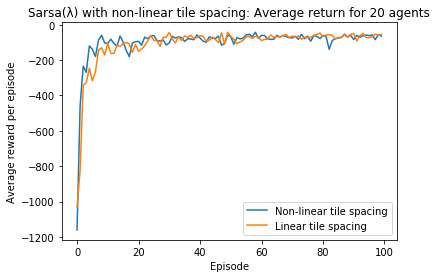

In [329]:
plt.plot(all_rewards_special, label='Non-linear tile spacing')
plt.plot(all_rewards, label='Linear tile spacing')
plt.title("Sarsa(λ) with non-linear tile spacing: Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward per episode')
plt.legend()
plt.show()

## (iii) Radial basis function

In [340]:
def play_rbf(env, num_episodes, alpha=0.05, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(48)
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    #Create centres
    centres = getCentres(4) # The 4 is the number of RBFs in one-direction, so makes a 4x4=16 grid.
    
    for episode in range(num_episodes):
        #print("Episode", episode)
        cumulative_reward = 0
        step = 0

        e = np.zeros(48)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            phi = calcPhi(state, action, centres)
            
            # Eligibility traces
            # I played around with this impementation as it is not clear in the textbook how to approach
            # eligibility traces when using RBFs. I found setting the trace to the degree to which the feature
            # is 'on' to be most effective.
            e = phi
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQa(phi, theta)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action_rbf(theta, state_, env.actions, centres)
            else:
                action_ = random.choice(env.actions)
                phi = calcPhi(state_, action, centres)
                Qa_ = calcQa(phi, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step

    return reward_per_episode, steps_per_episode
            

In [195]:
def e_greedy_action_rbf(theta, s, actions, centres):
        Q = np.zeros(3)
        for a in actions:
            phi = calcPhi(s, a, centres)
            Qa = calcQa(phi, theta)
            Q[a + 1] = Qa
        maxQ = max(Q)
        if (Q == maxQ).sum() > 1:
            best = [i for i in range(len(actions)) if Q[i] == maxQ]
            i = random.choice(best)
        else:
            i = np.argmax(Q)
        action = actions[i]
        Qa = Q[i]
        return action, Qa

In [177]:
def calcQa(phi, theta):
    Qa = np.dot(theta.T, phi)
    return Qa

In [221]:
def calcPhi(state, action, centres):
    p = state[0]
    v = state[1]
    norm_p = (p - (-1.2)) / 1.7
    norm_v = (v - (-0.07)) / 0.14
    state = np.array([norm_p, norm_v])
    
    action_index = action + 1
    
    sigma = 0.35

    phi = []
    for a in range(3):
        for c in centres:
            if a == action_index:
                phi.append(np.exp(-(np.linalg.norm(state - c)) ** 2 / (2 * (sigma ** 2))))
            else:
                phi.append(0)
        
    return np.array(phi)

#calcPhi([-0.5, 0.023], 0, centres)

In [338]:
def getCentres(n):
    centres = []
    for i in range(n):
        x = (1 / (n-1)) * i
        for j in range(n):
            y = (1 / (n-1)) * j
            centres.append([x, y])
    return centres

In [343]:
n_agents = 20
num_episodes = 100
all_rewards_rbf = np.zeros(num_episodes)
all_steps_rbf = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards, steps = play_rbf(env, num_episodes, alpha=0.03, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False)
    all_rewards_rbf += rewards
    all_steps_rbf += steps
    print("Agent", i+1, " complete")

all_rewards_rbf = all_rewards_rbf / n_agents
all_steps_rbf = all_steps_rbf / n_agents

Agent 1  complete
Agent 2  complete
Agent 3  complete
Agent 4  complete
Agent 5  complete
Agent 6  complete
Agent 7  complete
Agent 8  complete
Agent 9  complete
Agent 10  complete
Agent 11  complete
Agent 12  complete
Agent 13  complete
Agent 14  complete
Agent 15  complete
Agent 16  complete
Agent 17  complete
Agent 18  complete
Agent 19  complete
Agent 20  complete


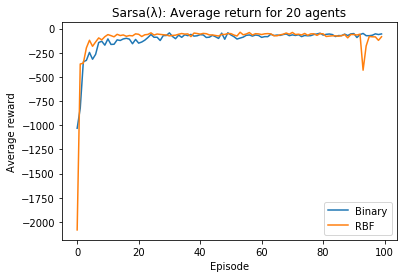

In [344]:
plt.plot(all_rewards, label='Binary')
plt.plot(all_rewards_rbf, label='RBF')
plt.title("Sarsa(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()

Please make sure that all of your code is above this cell. Please insert a static learning curve, showing the performance of your learning over time, and answer the questions provided on the coursework specification. Instead of providing your answer here, in this Jupyter notebook, you have the option to provide your answers on a separate pdf document, not exceeding two pages in length. If you do so, please write "Answer in pdf file." in this cell.

## Radial basis functions and Watkin's Q(λ)

### Explain the rationale for your approach

My approach to this part of the coursework consists of three parts. The first part was to implement the Watkin's Q(λ) algorithm instead of Sarsa(λ). The second part then used non-linear tile spacing in the 'position' axis and used the standard Sarsa(λ) algorithm again. The third and final part was to implement a Radial Basis Function (RBF) instead of the binary tile coding.

(i) The rationale for implementing the Watkin's Q(λ) algorithm is that it is an off-policy learning algorithm compared to Sarsa which is on-policy. The action with the maximum Q-value in a given state is chosen instead of following the policy (epsilon-greedy). Sarsa (on-policy) will find an optimal policy that takes into account the exploration inherent in the policy. However, exploration is not costly in mountain car and so this is not that necessary here. Therefore, I believe Watkin's algorithm will lead to a better policy. Furthermore, Watkin's algorithm zeroes out eligibility traces after a non-greedy action is taken, because this random action should not be credited with helping to get future reward. This is in contrast to Sarsa which gives an eligibility trace to every action taken. I think that not giving credit to these random state-action pairs will lead to an efficiency improvement since the agent will not learn to 'waste time' choosing those actions in those states in the future, thus getting to the optimal policy faster.

(ii) The non-linear tile spacing only affects the position axis and uses small intervals at either end and more sparse spacing in the middle. This is to make the tile spacing narrower around the highest point on the left-hill and at the goal. By doing this, features are more sensitive to changes around these points, which I believe are the most important points that the agent needs to learn what to do at. For example, the car needs to put on full throttle when moving down the left-hill so the car gathers momentum to get up to the goal. Additionally, if the car gets near to the goal it needs to keep using throttle to get over the last bit and not stop. I believe this will lead to a better policy as a result.

(iii) The rationale for implementing RBFs is that an RBF reflects the various degrees to which a feature is present, rather than a binary on-off degree that was used previously. This is achieved by using the RBF formula to generate a value for each 'state' in the range [0,1]. The image below is an illustration of how this continuous feature weighting works. The colour represents the weighting assigned to parts of the state space. Closer to the centre of the RBF gives a higher weighting.

<img src="images/heatmap.png" style="width: 250px;" align="middle"/>

The distance metric I have used in my RBFs is the straight-line distance between the 'state' (s) and the centre of each RBF i (ci). The feature width used was 0.35. I choose to use 16 RBFs evenly spaced in a grid-formation across the state space in order to sufficiently cover all of it. The below diagram illustrates where the RBF centres are placed.

<img src="images/rbf_spacing.png" style="width: 300px;" align="middle"/>

I think that this approach will improve the efficiency of the algorithm since far more features are given a weight and these weights are relative to how 'present' the feature is. Therefore, the theta values should converge towards their true values faster.


### Description of results and discussion of findings

(i) The Watkin's Q(λ) algorithm shows no clear improvement over the Sarsa algorithm, with an arguably worse efficiency shown by the increasing number of steps at the beginning episodes. Furthermore, there was no improvement in the optimal policy. This finding would imply that on-policy learning is better for mountain car, contrary to my previous prediction. However, more concrete testing would be needed to verify this which is beyond the time we have for this coursework. One thought I had was that this efficiency decrease may be attributed to the eligibility trace 'cutting out' (for lack of a better word) frequently in the early episodes, resulting in 'short' traces and not many state-action pairs being updated. This would indicate that including random moves in the updates does not negatively impact the learning. 

<img src="images/watkins_vs_sarsa.png" style="width: 400px;" align="middle"/>

(ii) The non-linear tile spacing needed fewer observations to get to the optimal policy and so resulted in an efficiency improvement. This is indicated by the circled area. However, there was no improvement in the algorithm's optimal policy as both learning curves plateau at the same level. This finding suggests that tile spacing is important for the efficiency of the learning process and that linear tile spacing is not necessarily the best approach, but that the tile spacing does not affect the optimal policy.

<img src="images/non_linear_tile_spacing.png" style="width: 400px;" align="middle"/>

(iii) My results show that the efficiency of the algorithm has increased as a result of using RBFs. This is indicated by smaller number of observations needed to reach the optimal policy. Although the learning curve starts lower, overall the observation count is lower for the agent to learn the optimal policy. This would indicate that continuous feature weighting instead of binary is better for efficiency of learning. However, I found an odd phenomenon -- divergence after learning the optimal policy. This appeared **very** sensitive to the alpha value, as can be seen when comparing the two graphs below (top: alpha=0.0375, bottom: alpha=0.03). A slightly lower alpha almost removed this divergence, but led to a slightly worse efficiency shown by the orange line starting lower than the blue. I cannot think why this divergence would occur after learning the optimal policy, so please can you provide some insight after marking?

<img src="images/rbf_16.png" style="width: 400px;" align="middle"/> <img src="images/rbf_16_lower_alpha.png" style="width: 400px;" align="middle"/>


### Did your approach work better or worse than you expected? 

The Watkin's implementation performed worse than expected. 

The non-linear tile coding worked as expected.

I do not think the RBF implementation worked better or worse than expected. The predicted efficiency improvement occurred, but it was small. In terms of computational complexity, it was worse than I expected. With the RBFs, the algorithm took much longer to compute. This is because rather than calculating 10 values to sum up with binary features, all features are 'on' to varying degrees and so the computation was more intensive.

### What did I learn

I learned how to implement a variation of coarse coding (RBFs), rather than just tile coding. I had not appreciated beforehand that features could be anything other than 'on' or 'off'!

I also learned (both in Part 1 and 2) that the alpha value is much more sensitive when using tile coding. Having too high an alpha value can lead to 'overshooting' in the gradient descent. 

### If you had more time, what other approaches would you try?

If I had more time, I would have liked to have tuned my radial basis functions beyond the manual tuning I conducted myself. I read that there are ways of working out where the best position is for the centres of the RBFs, how many RBFs to use and also what feature width to use. Tuning these parameters would likely have led to further improvements in efficiency. I also think it would have been interesting to vary the standard deviations of the radial basis functions along a similar concept to the non-linear tile spacing I conducted i.e. maybe 'tighter' RBFs nearer the goal state and top of the left hill may improve the algorithm. 

I would also like to try implementing different shapes beyond the rectangular shapes I implemented. I think hexagonal shapes would be interesting due to their neat mesh-like properties when fitted together (I am thinking about a honeycomb-like structure!). 
